# Forecast (Vintage-aware 1-step Holt–Winters)

- Based on the visualisation, the vacancy series shows **limited variation over time, with no persistent trend or seasonality but occasional level shifts**.

- Each ONS release (vintage) includes observations only up to roughly one or two months prior to its publication date, reflecting the **reporting lag** inherent in official vacancy statistics.
- These reporting lags and occasional revisions create sharp discontinuities across vintages — **pooling them would mix outdated estimates with later updates, producing misleadingly smooth or biased forecasts**.

- To address this, we adopt **a vintage-aware 1-step ahead evaluation**, where models are re-fitted at each publication date using only the information available at that time to forecast the next month (T+1).

- We first implement a naive last-value forecast as a baseline, then apply **a lightweight Holt–Winters exponential smoothing model to test whether simple exponential adjustment improves short-term adaptability**.

- Because **revisions are small relative to the overall level of the series**, forecast accuracy is evaluated mainly using **MAE and sMAPE**, which better capture relative performance in low-variance data.


## 0. Data/Package preparation

In [1]:
TIDY_CSV = "../data/processed/AP2Y_tidy.csv"  # Path to the tidy dataset

In [2]:
# Import packages
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# Load tidy data
df = pd.read_csv(TIDY_CSV, parse_dates=["observation_month","vintage_date"])
display(df.head())

,observation_month,vintage_date,value
0,2001-05-01,2023-03-14,680.0
1,2001-05-01,2023-04-18,680.0
2,2001-05-01,2023-05-16,680.0
3,2001-05-01,2023-06-13,680.0
4,2001-05-01,2023-07-11,680.0


In [4]:
# Final series as the forecast target for evaluation (y_true)
final_series = (
    df.sort_values(['observation_month','vintage_date'])
      .groupby('observation_month')['value']
      .last()
      .sort_index()
)
display(final_series.tail(12))

observation_month
2024-08-01    832.0
2024-09-01    823.0
2024-10-01    807.0
2024-11-01    806.0
2024-12-01    804.0
2025-01-01    799.0
2025-02-01    783.0
2025-03-01    762.0
2025-04-01    739.0
2025-05-01    726.0
2025-06-01    720.0
2025-07-01    728.0
Name: value, dtype: float64

## 1. Model training and setup

We train a simple **Holt–Winters exponential smoothing** model under a **vintage-aware 1-step ahead** setup, 
re-fitting the model at each publication date to forecast the next month (T+1).  
A **naive last-value forecast** is included only as a baseline reference for comparison.

In [5]:
# Minimal vintage-aware 1-step ahead evaluation

MIN_HISTORY = 30          # minimum number of months to fit a stable model
SP = 12                   # seasonal periods for monthly data
TREND = 'add'             # 'add' or 'mul' or None
SEASONAL = 'add'          # 'add' or 'mul' or None

rows_hw = []
rows_naive = []
for cutoff in sorted(df['vintage_date'].unique()):
    # Data known at cutoff
    known = (
        df[df['vintage_date'] <= cutoff]
        .sort_values(['observation_month','vintage_date'])
        .groupby('observation_month')['value'].last()
        .sort_index()
    ).asfreq('MS')

    # Require enough history
    if known.isna().all() or len(known.dropna()) < MIN_HISTORY:
        continue

    # Target month = next month after last known observation
    last_month = known.index.max()
    target = last_month + pd.offsets.MonthBegin(1)

    # Need finalized truth for target
    if target not in final_series.index:
        continue

    # Holt–Winters forecast
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model = ExponentialSmoothing(
                known, trend=TREND, seasonal=SEASONAL,
                seasonal_periods=SP, initialization_method='estimated'
            ).fit(optimized=True)
        yhat_hw = float(model.forecast(1).iloc[0])
    except Exception:
        # Fallback to naive if HW fails
        yhat_hw = float(known.iloc[-1])

    # Naive baseline (last value)
    yhat_naive = float(known.iloc[-1])
    ytrue = float(final_series.loc[target])

    cutoff_ts = pd.Period(pd.to_datetime(cutoff), freq='M').to_timestamp()
    rows_hw.append({'model':'HW', 'cutoff': cutoff_ts, 'target_month': target, 'y_true': ytrue, 'y_pred': yhat_hw})
    rows_naive.append({'model':'Naive', 'cutoff': cutoff_ts, 'target_month': target, 'y_true': ytrue, 'y_pred': yhat_naive})

va_hw = pd.DataFrame(rows_hw).sort_values('cutoff').reset_index(drop=True)
va_nv = pd.DataFrame(rows_naive).sort_values('cutoff').reset_index(drop=True)

display(va_hw.tail())

,model,cutoff,target_month,y_true,y_pred
24,HW,2025-04-01,2025-03-01,762.0,756.618930
25,HW,2025-05-01,2025-04-01,739.0,742.630946
26,HW,2025-06-01,2025-05-01,726.0,711.558926
27,HW,2025-07-01,2025-06-01,720.0,724.182363
28,HW,2025-08-01,2025-07-01,728.0,709.322392


## 2. Evaluation protocol and metrics

**Protocol:**  
For each cutoff vintage:
1. Fit the model using only data available up to that vintage.  
2. Forecast the next month (T+1).  
3. Compare the forecast against the finalized ("truth") series.

**Choice of metrics:**  
**Since the vacancy level itself is large (≈700–1100) but the month-to-month revisions are small (typically within ±15),**  
scale-sensitive metrics like RMSE can exaggerate forecast errors.  
We therefore focus on **MAE** and **sMAPE**:
- **MAE (Mean Absolute Error)** — intuitive, reflects the average revision in absolute terms.  
- **sMAPE (Symmetric Mean Absolute Percentage Error)** — scale-free, better suited when relative changes are small.  

In [6]:
# Evaluation metrics

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1.0
    return float(np.mean(2.0 * np.abs(y_pred - y_true) / denom))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def summarize_va(df: pd.DataFrame, name: str):
    if df.empty:
        return pd.DataFrame([{'model': name, 'MAE': np.nan, 'RMSE': np.nan, 'sMAPE': np.nan, 'N': 0}])
    return pd.DataFrame([{
        'model': name,
        'MAE': mae(df['y_true'], df['y_pred']),
        'sMAPE': smape(df['y_true'], df['y_pred'])
    }])

metrics = pd.concat([
    summarize_va(va_nv, 'Naive (1-step, vintage-aware)'),
    summarize_va(va_hw, 'Holt–Winters (1-step, vintage-aware)')
], ignore_index=True)

display(metrics)

,model,MAE,sMAPE
0,"Naive (1-step, vintage-aware)",21.103448,0.023530
1,"Holt–Winters (1-step, vintage-aware)",13.243475,0.015173


## 3. Plot — Actual vs Real-time Forecast (1-step ahead)

We compare:
- **Finalized truth** — the latest available series (best estimate of actual vacancies).  
- **Real-time forecasts** — 1-step ahead predictions from Naive and Holt–Winters models.  

Purpose:
- Visualize how real-time forecasts aligned with the eventual truth.  
- Assess whether Holt–Winters improved upon the naive baseline.  
- Identify any systematic bias or lag in the forecast updates.

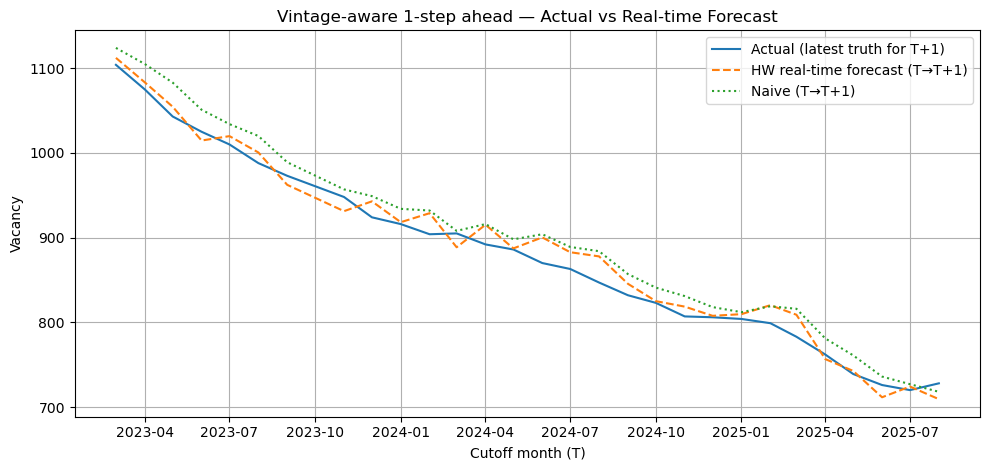

In [7]:
    plt.figure(figsize=(10,4.8))
    plt.plot(va_hw['cutoff'], va_hw['y_true'], label='Actual (latest truth for T+1)')
    plt.plot(va_hw['cutoff'], va_hw['y_pred'], linestyle='--', label='HW real-time forecast (T→T+1)')
    plt.plot(va_nv['cutoff'], va_nv['y_pred'], linestyle=':', label='Naive (T→T+1)')
    plt.title('Vintage-aware 1-step ahead — Actual vs Real-time Forecast')
    plt.xlabel('Cutoff month (T)')
    plt.ylabel('Vacancy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4. Evaluation

**Results:**  
- **Holt–Winters** generally outperformed the naive baseline across evaluation cutoffs.
- **MAE** decreased from ~21.1 (Naive) to ~13.2 (HW), and **sMAPE** improved from 2.3% to 1.5% —  
  a relative improvement of roughly **35%**.  
- Given that vacancy levels ranged roughly **700–1100**, both models achieve small absolute errors  
  (≈1–2% of the overall level), confirming the series’ inherent stability.

**Interpretation:**  
- Both models perform well given the series’ low volatility, but **Holt–Winters** adapts more effectively to level shifts and revisions, leading to modest but consistent improvements over the naive baseline.
- This demonstrates that **simple exponential smoothing is sufficient** to handle **small structural changes
in a largely stable series**.

## 5. Next Steps

Several practical extensions could strengthen the analysis:

- **Forecast evaluation and monitoring**  
  Extend the vintage-aware evaluation to multi-step horizons (e.g. 3–6 months ahead)  
  and monitor how real-time forecast accuracy evolves as new vintages are released.

- **Uncertainty communication**  
  Add simple prediction intervals around forecasts to convey the expected range of revisions.

- **Revision analysis**  
  Quantify how strongly initial estimates are revised over time,  
  identifying periods or conditions with systematically larger adjustments.

- **Automation and reproducibility**  
    The current workflow already automates data download and tidying through `fetch_vintages.py` and `build_tidy.py`. This could be extended into a fully scheduled pipeline that updates automatically whenever new ONS vintages are published, refreshing both the tidy dataset and forecasts.
